<a href="https://colab.research.google.com/github/BrunaFerreira/Mestrado_UNIFESP/blob/main/2_Resnet50_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Bibliotecas a serem utilizadas


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import PIL
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from torchvision import models, transforms
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
pd.options.display.float_format = '{:.2f}'.format
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

## 2. Leitura dos dados (imagens de glandulas salivares)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/files_csv/HarmonicSS_Split_V5.csv')
dir = '/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/dataset'
df.head()

,ID,Sex,Faixa_Etaria,Label_pSS,Image,Base
0,1,F,Above 40,1,001.jpg,train
1,2,F,Above 40,1,002.jpg,test
2,3,F,Above 40,0,003.jpg,train
3,4,F,Above 40,0,004.jpg,train
4,5,F,Above 40,0,005.jpg,train


### Pre Processar imagens para usar na Resnet50

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = ImageFolder(dir + '/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

## Treinamento

### Instancia Modelo

Classifier do Resnet50. O Resnet50 tem três camadas lineares na cabeça (classifier), e a camada [1] não é a de saída final. A correta é [6].

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ==== 1. Carregar ResNet50 pré-treinado ====
model = models.resnet50(pretrained=True)

# ==== 2. Adaptar a última camada ====
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ==== 3. Preparar os rótulos ====
y = torch.tensor(df['Label_pSS'].values)

# ==== 4. Calcular pesos de classe ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ==== 5. Configurar dispositivo, loss e otimizador ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Treino Modelo

In [ ]:

def train(model, loader, epochs=5):
    train_loss_history = []
    train_acc_history = []
    epoch_hist = []
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        train_loss_history.append(avg_loss)
        train_acc_history.append(accuracy)
        epoch_hist.append(epoch+1)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return (epoch_hist, train_loss_history,train_acc_history)

In [ ]:
def graf_loss (_model,_loader, n_epocs ):
  start_time = time.time()
  epochs_, loss_train,train_acc = train(_model, _loader, epochs= n_epocs)
  end_time = time.time()
  print(f"Execution Time: {end_time - start_time} seconds")
  plt.figure(figsize=(12, 5))

  # Gráfico de Loss
  plt.plot(epochs_, loss_train, label='Loss', linewidth=3, color = 'red')
  plt.title('Loss and Accuracy per Epoch')

  # Gráfico de Acurácia
  #plt.subplot(1, 2, 2)
  plt.plot(epochs_, train_acc, label='Acuracy', linewidth=3, color = 'green')
  plt.title('Loss and Accuracy per Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Values')
  plt.legend()
  plt.tight_layout()
  plt.show()


Epoch [1/50], Loss: 0.6451, Accuracy: 0.7949
Epoch [2/50], Loss: 0.3280, Accuracy: 0.8205
Epoch [3/50], Loss: 0.1348, Accuracy: 0.9808
Epoch [4/50], Loss: 0.0501, Accuracy: 0.9872
Epoch [5/50], Loss: 0.0258, Accuracy: 1.0000
Epoch [6/50], Loss: 0.0089, Accuracy: 1.0000
Epoch [7/50], Loss: 0.0100, Accuracy: 1.0000
Epoch [8/50], Loss: 0.0031, Accuracy: 1.0000
Epoch [9/50], Loss: 0.0029, Accuracy: 1.0000
Epoch [10/50], Loss: 0.0029, Accuracy: 1.0000
Epoch [11/50], Loss: 0.0019, Accuracy: 1.0000
Epoch [12/50], Loss: 0.0016, Accuracy: 1.0000
Epoch [13/50], Loss: 0.0021, Accuracy: 1.0000
Epoch [14/50], Loss: 0.0030, Accuracy: 1.0000
Epoch [15/50], Loss: 0.0015, Accuracy: 1.0000
Epoch [16/50], Loss: 0.0011, Accuracy: 1.0000
Epoch [17/50], Loss: 0.0022, Accuracy: 1.0000
Epoch [18/50], Loss: 0.0012, Accuracy: 1.0000
Epoch [19/50], Loss: 0.0011, Accuracy: 1.0000
Epoch [20/50], Loss: 0.0010, Accuracy: 1.0000
Epoch [21/50], Loss: 0.0010, Accuracy: 1.0000
Epoch [22/50], Loss: 0.0012, Accuracy: 1.00

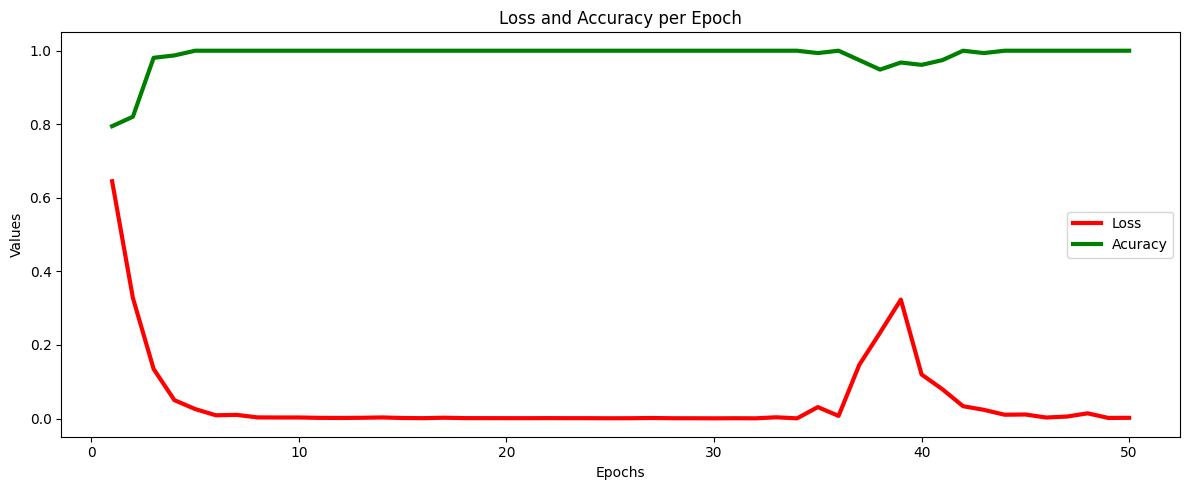

In [ ]:
graf_loss (model,train_loader, 50)

### Inferencia conjunto de teste

In [ ]:
from PIL import Image
import numpy as np
import os
import torch

# Pasta com imagens de teste
dir_test = os.path.join(dir, "test")

# Classes: a ordem deve ser a mesma usada durante o treinamento
# Ex: 0 = 'sem doença', 1 = 'com doença'
classes = ['0', '1']  # ou ['Negative', 'Positive'], conforme seu label_map

# Guardar os resultados
resultados = []

model.eval()  # Importante: coloca o modelo em modo de avaliação

with torch.no_grad():
    for nome_arquivo in os.listdir(dir_test):
        if nome_arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
            caminho_imagem = os.path.join(dir_test, nome_arquivo)

            # Abrir imagem e aplicar transform
            imagem = Image.open(caminho_imagem).convert("RGB")
            imagem_tensor = transform(imagem).unsqueeze(0).to(device)

            # Predição
            output = model(imagem_tensor)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]

            classe_predita = np.argmax(probs)
            conf = probs[classe_predita]

            resultados.append({
                'arquivo': nome_arquivo,
                'predicted_label': classes[classe_predita],
                'probabilidade': round(float(conf), 4)
            })

In [ ]:
test_df = df[df['Base']=='test']
previsoes  = pd.DataFrame(resultados)
previsoes.columns = ['Image', 'predicted_label', 'Probability']
result = pd.merge(test_df, previsoes, on="Image", how="left")
result.head()

,ID,Sex,Faixa_Etaria,Label_pSS,Image,Base,predicted_label,Probability
0,2,F,Above 40,1,002.jpg,test,1,1.00
1,7,F,Above 40,1,007.jpg,test,1,1.00
2,13,M,Above 40,1,013.jpg,test,1,1.00
3,14,F,Above 40,1,014.jpg,test,1,1.00
4,16,F,Above 40,0,016.jpg,test,1,1.00


### Avaliação

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def metricas (df, y_true, y_pred, title_cm):

  auc = roc_auc_score(df[y_true], df[y_pred])
  f1 = f1_score(df[y_true], df[y_pred])
  acuracia = accuracy_score(df[y_true], df[y_pred])
  precision = precision_score(df[y_true], df[y_pred])
  recall = recall_score(df[y_true], df[y_pred])

  # Exemplo: y_true, y_pred e class_names
  cm = confusion_matrix(df[y_true], df[y_pred])

  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu',
              xticklabels=['Without Sjogren','With Sjogren'], yticklabels=['Without Sjogren','With Sjogren'],
              annot_kws={"size": 14})  # Fonte dos números internos

  plt.xlabel('Predicted Label', fontsize=12)
  plt.ylabel('True Label', fontsize=12)
  plt.title(title_cm, fontsize=14)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.tight_layout()

  return auc*100, f1*100, acuracia*100, precision*100, recall*100

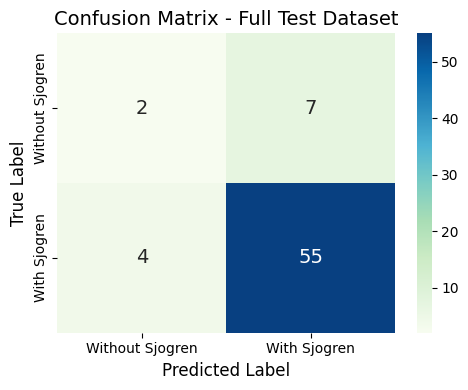

In [ ]:
df_fairness  = pd.DataFrame()
result['Label_pSS'] = result['Label_pSS'].astype(int)
result['predicted_label'] = result['predicted_label'].astype(int)

df_fairness['Full Dataset'] = metricas (result, "Label_pSS", "predicted_label", 'Confusion Matrix - Full Test Dataset')

## Fairness

### Idade

In [ ]:
result.head()

,ID,Sex,Faixa_Etaria,Label_pSS,Image,Base,predicted_label,Probability
0,2,F,Above 40,1,002.jpg,test,1,1.00
1,7,F,Above 40,1,007.jpg,test,1,1.00
2,13,M,Above 40,1,013.jpg,test,1,1.00
3,14,F,Above 40,1,014.jpg,test,1,1.00
4,16,F,Above 40,0,016.jpg,test,1,1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


,Full Dataset,Age <= 40 years,Age > 40 years
0,57.72,NaN,57.26
1,90.91,100.00,89.72
2,83.82,100.00,81.97
3,88.71,100.00,87.27
4,93.22,100.00,92.31


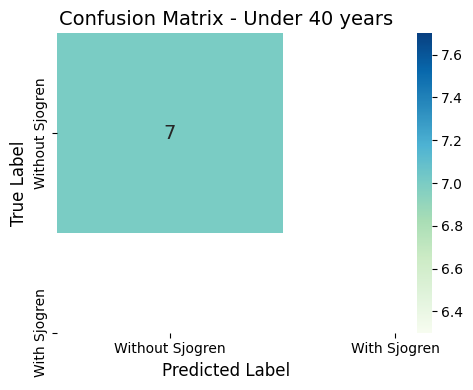

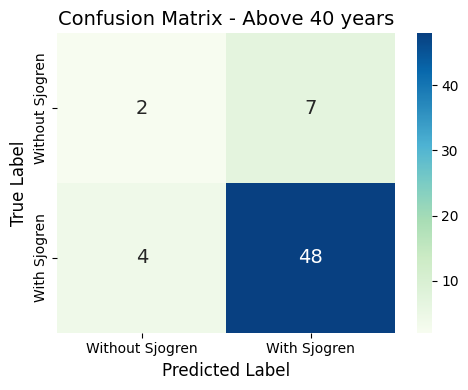

In [ ]:
df_age_ate40 = result[result['Faixa_Etaria']=='Under 40']
df_fairness['Age <= 40 years'] = metricas (df_age_ate40, "Label_pSS", "predicted_label", 'Confusion Matrix - Under 40 years')

df_age_mais40 = result[result['Faixa_Etaria']=='Above 40']
df_fairness['Age > 40 years'] = metricas (df_age_mais40, "Label_pSS", "predicted_label", 'Confusion Matrix - Above 40 years')

df_fairness

### Sexo

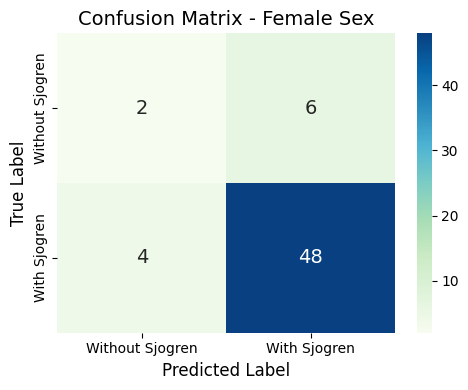

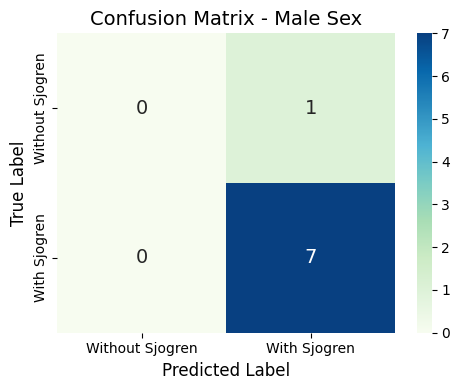

In [ ]:
df_sex_F = result[result['Sex']== 'F']
df_fairness['Female'] = metricas (df_sex_F, "Label_pSS", "predicted_label", 'Confusion Matrix - Female Sex')

df_sex_M = result[result['Sex']== 'M']
df_fairness['Male'] = metricas (df_sex_M, "Label_pSS", "predicted_label", 'Confusion Matrix - Male Sex')

In [ ]:
df_fairness.set_index(pd.Index(['AUC', 'F1', 'Acuracy', 'Precision', 'Recall']), inplace=True)
df_fairness

,Full Dataset,Age <= 40 years,Age > 40 years,Female,Male
AUC,57.72,NaN,57.26,58.65,50.00
F1,90.91,100.00,89.72,90.57,93.33
Acuracy,83.82,100.00,81.97,83.33,87.50
Precision,88.71,100.00,87.27,88.89,87.50
Recall,93.22,100.00,92.31,92.31,100.00
